In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


# Load data

In [2]:
# use pandas to load your data to dataframe objects
import pandas as pd

# load the training, testing, and sample submission data
training_data = pd.read_csv(r'/kaggle/input/playground-series-s5e2/train.csv')
training_extra = pd.read_csv(r'/kaggle/input/playground-series-s5e2/training_extra.csv')
testing_data = pd.read_csv(r'/kaggle/input/playground-series-s5e2/test.csv')
sample_submission = pd.read_csv(r'/kaggle/input/playground-series-s5e2/sample_submission.csv')

# verify the data was loaded
for dataset in [training_data, training_extra, testing_data, sample_submission]:
    print(f"dataset shape: {dataset.shape}")

dataset shape: (300000, 11)
dataset shape: (3694318, 11)
dataset shape: (200000, 10)
dataset shape: (200000, 2)


In [3]:
training_data.head(2)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056


In [4]:
training_extra.head(2)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972


# Data Profiling

In [5]:
# data profiling function
def create_data_profiling_df(data: pd.DataFrame) -> pd.DataFrame:

    # create an empty dataframe to gather information about each column
    data_profiling_df = pd.DataFrame(columns = ["column_name",
                                                "data_type",
                                                "values",
                                                "null_values",
                                                "percent_null",
                                                "unique_values",
                                                "duplicate_values",
                                                "min",
                                                "max",
                                                "median",
                                                "stdev",
                                                "IQR",
                                                "skewness",
                                                "most_common_value",
                                                "outliers"])

    # loop through each column to add rows to the data_profiling_df dataframe
    for column in data.columns:

        # create an empty dictionary to store the columns data
        column_dict = {}

        try:
            column_dict["column_name"] = [column]
            column_dict["data_type"] = [data[column].dtypes]
            column_dict["values"] = [data[column].notnull().sum()]
            column_dict["null_values"] = [data[column].isna().sum()]
            column_dict["percent_null"] = [round(data[column].isna().sum() / len(data[column]), 2)]
            column_dict["unique_values"] = [len(data[column].unique())]
            column_dict["duplicate_values"] = [(data[column].notnull().sum()) - len(data[column].unique())]
            column_dict["min"] = [data[column].min() if (data[column].dtypes != object) else "NA"]
            column_dict["max"] = [round(data[column].max(), 1) if (data[column].dtypes != object) else "NA"]
            column_dict["mean"] = [round(data[column].mean(), 1) if (data[column].dtypes != object) else "NA"]
            column_dict["median"] = [round(data[column].median(), 1) if (data[column].dtypes != object) else "NA"]
            column_dict["stdev"] = [round(data[column].std(), 1) if (data[column].dtypes != object) else "NA"]
            column_dict["IQR"] = [round(data[column].quantile(.75), 1) - data[column].quantile(.25) if (data[column].dtypes != object) else "NA"]
            column_dict["most_common_value"] = data[column].mode().iloc[0] if not data[column].mode().empty else "NA"
            column_dict["skewness"] = [data[column].skew(skipna=True) if (data[column].dtypes != object) else "NA"]

            # calculate likely outliers
            if data[column].dtypes != object:
                Q1 = data[column].quantile(0.25)
                Q3 = data[column].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column]
                column_dict["outliers"] = len(outliers)
            else:
                column_dict["outliers"] = "NA"

        except:
            print(f"unable to read column: {column}, you may want to drop this column")

        # add the information from the columns dict to the final dataframe
        data_profiling_df = pd.concat([data_profiling_df, pd.DataFrame(column_dict)],
                                      ignore_index = True)

    # sort the final dataframe by unique values descending
    data_profiling_df.sort_values(by = ['unique_values'],
                                  ascending = [False],
                                  inplace=True)

    # print the function is complete
    print(f"data profiling complete, dataframe contains {len(data_profiling_df)} columns")
    return data_profiling_df

In [6]:
#Combine the 2 training dataframes
training_data_combined = pd.concat([training_data, training_extra], ignore_index=True)

#run data profiling functions on the newly combined training data
data_profiling_df = create_data_profiling_df(data = training_data_combined)

#print out the data profiling df
data_profiling_df

<ipython-input-5-148ed7339d30>:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_profiling_df = pd.concat([data_profiling_df, pd.DataFrame(column_dict)],


data profiling complete, dataframe contains 11 columns


,column_name,data_type,values,null_values,percent_null,unique_values,duplicate_values,min,max,median,stdev,IQR,skewness,most_common_value,outliers,mean
0,id,int64,3994318,0,0.00,3994318,0,0,4194317,2197158.5,1178058.0,1997158.55,-0.066548,0,0,2182137.2
9,Weight Capacity (kg),float64,3992510,1808,0.00,1920346,2072164,5.0,30.0,18.1,7.0,11.931036,-0.061311,5.0,0,18.0
10,Price,float64,3994318,0,0.00,48358,3945960,15.0,150.0,81.0,38.9,67.42998,0.036958,150.0,0,81.4
4,Compartments,float64,3994318,0,0.00,10,3994308,1.0,10.0,5.0,2.9,5.0,0.033133,1.0,0,5.4
8,Color,object,3860701,133617,0.03,7,3860694,NA,NA,NA,NA,NA,NA,Pink,NA,NA
1,Brand,object,3867560,126758,0.03,6,3867554,NA,NA,NA,NA,NA,NA,Under Armour,NA,NA
2,Material,object,3883356,110962,0.03,5,3883351,NA,NA,NA,NA,NA,NA,Polyester,NA,NA
3,Size,object,3906533,87785,0.02,4,3906529,NA,NA,NA,NA,NA,NA,Medium,NA,NA
7,Style,object,3890138,104180,0.03,4,3890134,NA,NA,NA,NA,NA,NA,Messenger,NA,NA
5,Laptop Compartment,object,3895785,98533,0.02,3,3895782,NA,NA,NA,NA,NA,NA,Yes,NA,NA


In [7]:
training_data_combined['Weight Capacity (kg)'].sample(10)

1726760    11.271688
992214     19.642623
2713817     8.917111
685562     14.279998
3290192     6.557515
2400368    12.510301
485859     21.732136
1629739    18.837673
603180     28.746280
1579727     9.310576
Name: Weight Capacity (kg), dtype: float64

# EDA

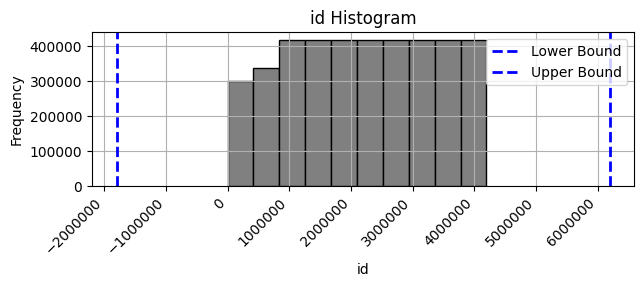

no potential outliers detected in id distribution
Lower Bound: -1797158.5, Upper Bound: 6191475.5

          -----
          


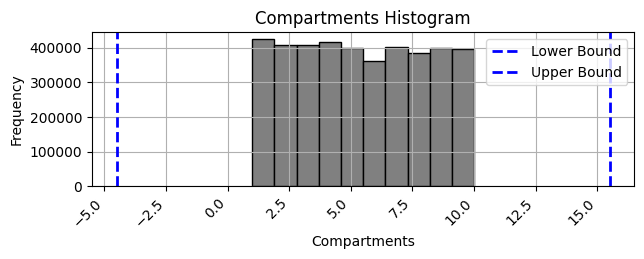

no potential outliers detected in Compartments distribution
Lower Bound: -4.5, Upper Bound: 15.5

          -----
          


/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


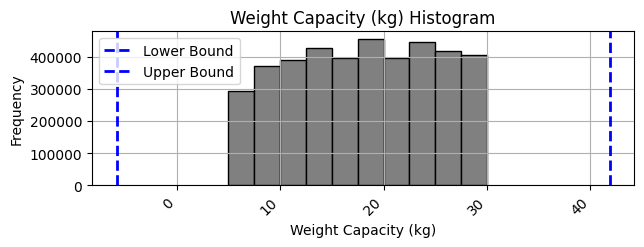

no potential outliers detected in Weight Capacity (kg) distribution
Lower Bound: -5.808848587583649, Upper Bound: 41.865317271220334

          -----
          


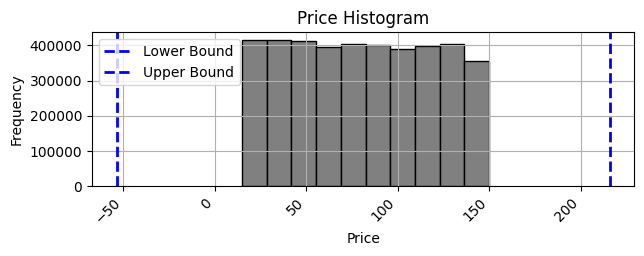

no potential outliers detected in Price distribution
Lower Bound: -53.60745000000002, Upper Bound: 215.93247000000002

          -----
          


In [8]:
# import needed libraries
import matplotlib.pyplot as plt
import seaborn as sns

# define function to plot histogram and identify outliers
def plot_histogram(df: pd.DataFrame,
                   variable: str,
                   bins=10,
                   color='grey',
                   edgecolor='black',
                   figsize=(7, 2),
                   iqr_on = False):

    # set the figure size
    plt.figure(figsize=figsize)

    # plot the histogram
    plt.hist(df[variable],
             bins=bins,
             color=color,
             edgecolor=edgecolor)

    # customize the plot labels and colors
    plt.title(f'{variable} Histogram')
    plt.xlabel(f'{variable}')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.ticklabel_format(style='plain', axis='x')
    plt.grid(True)

    # define the Inter Quartile Range (iqr) and outlier bounds
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3 - q1
    if iqr_on == True:
      lower_bound = q1
      upper_bound = q3
    else:
      lower_bound = q1 - 1.5 * iqr
      upper_bound = q3 + 1.5 * iqr

    # mark the outlier boundson the histogram
    plt.axvline(lower_bound, color='blue', linestyle='dashed', linewidth=2, label='Lower Bound')
    plt.axvline(upper_bound, color='blue', linestyle='dashed', linewidth=2, label='Upper Bound')

    # Show the plot
    plt.legend()
    plt.show()

    # count the outliers
    num_outliers = ((df[variable] < lower_bound) | (df[variable] > upper_bound)).sum()

    # print information about outliers
    if num_outliers > 0:
        print(f"{num_outliers} potential outliers detected in {variable} distribution")
        print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    else:
        print(f"no potential outliers detected in {variable} distribution")
        print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

    # print a new line
    print("""
          -----
          """)

# run the histogram function on all numerical features
for feature in training_data_combined.select_dtypes(include=['int64', 'float64']).columns.tolist():
    plot_histogram(df = training_data_combined,
                   variable = feature,
                   bins = 10)

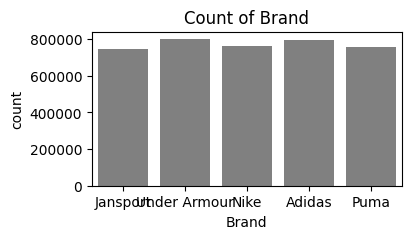


    -----
    


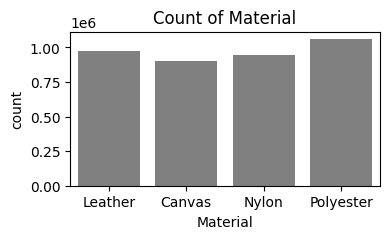


    -----
    


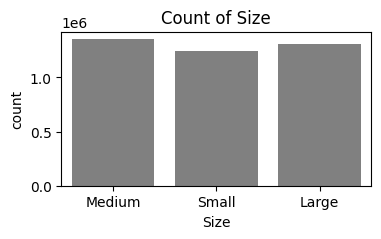


    -----
    


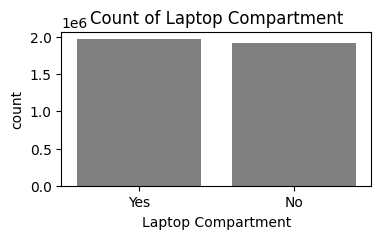


    -----
    


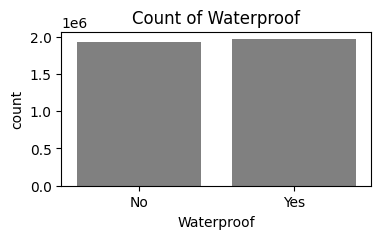


    -----
    


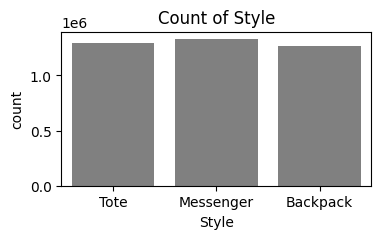


    -----
    


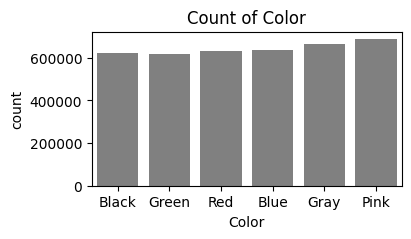


    -----
    


In [9]:
# create a function to make a bar chart of the count of categorical variables
def count_plot(df: pd.DataFrame,
               variable: str):

    plt.figure(figsize=(4, 2))
    sns.countplot(data = df,
                  x = f"{variable}",
                  color = "grey")
    plt.title(f'Count of {variable}')
    plt.xlabel(f'{variable}')
    plt.ylabel('count')
    plt.show()
    print("""
    -----
    """)

for feature in training_data_combined.select_dtypes(include=['object', 'bool']).columns.tolist():
    count_plot(df = training_data_combined,
               variable = feature)

<Axes: xlabel='Price', ylabel='Brand'>

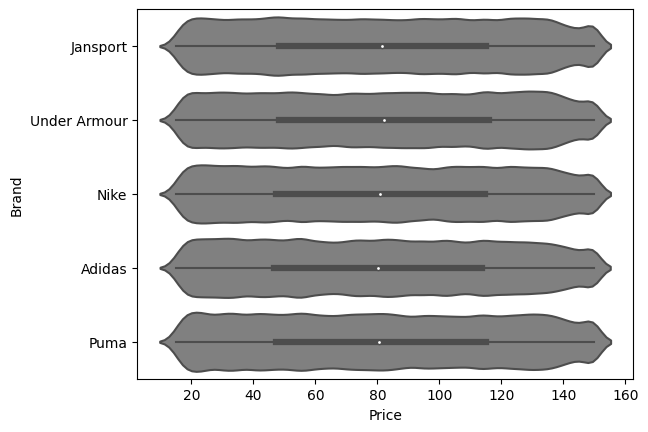

In [10]:
import seaborn as sns

sns.violinplot(data=training_data_combined,  
              x="Price",  
              y="Brand",  
              color="grey")  


<Axes: xlabel='Price', ylabel='Material'>

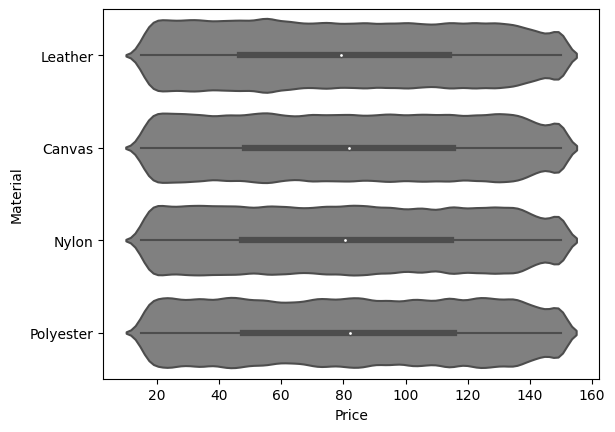

In [11]:
import seaborn as sns

sns.violinplot(data=training_data_combined,  
              x="Price",  
              y="Material",  
              color="grey")  

<Axes: xlabel='Price', ylabel='Color'>

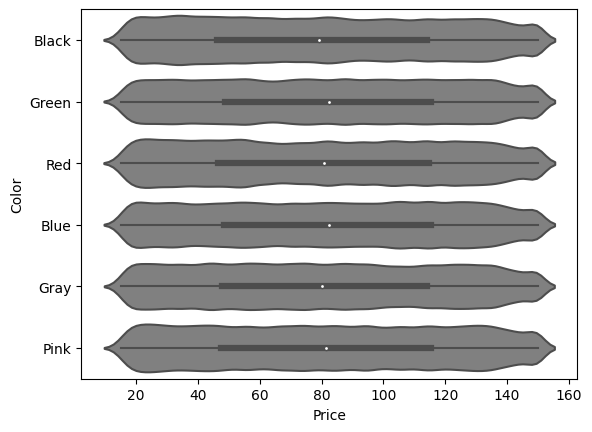

In [12]:
import seaborn as sns

sns.violinplot(data=training_data_combined,  
              x="Price",  
              y="Color",  
              color="grey")  

<Axes: xlabel='Price', ylabel='Style'>

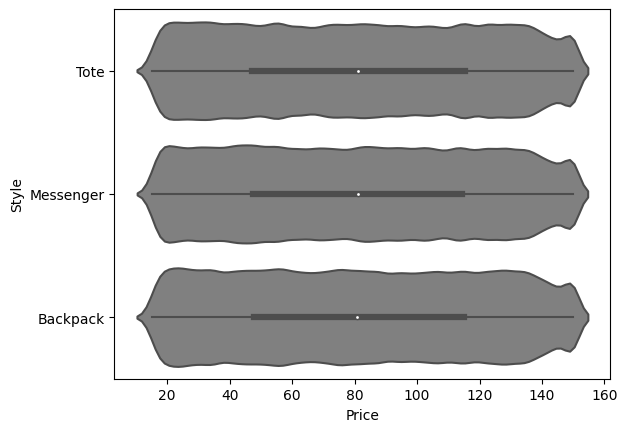

In [13]:
import seaborn as sns

sns.violinplot(data=training_data_combined,  
              x="Price",  
              y="Style",  
              color="grey")  

<Axes: xlabel='Price', ylabel='Size'>

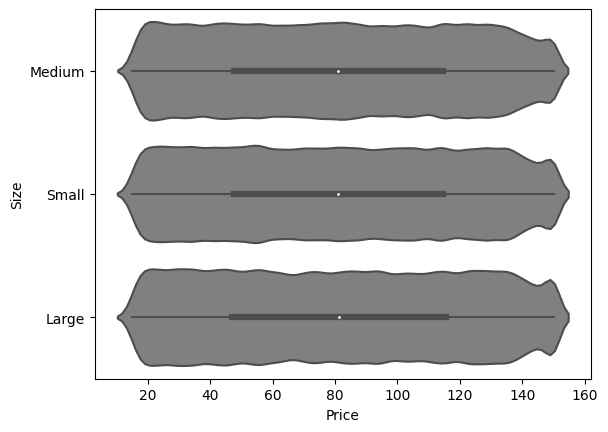

In [14]:
import seaborn as sns

sns.violinplot(data=training_data_combined,  
              x="Price",  
              y="Size",  
              color="grey")  

<Axes: xlabel='Weight Capacity (kg)', ylabel='Price'>

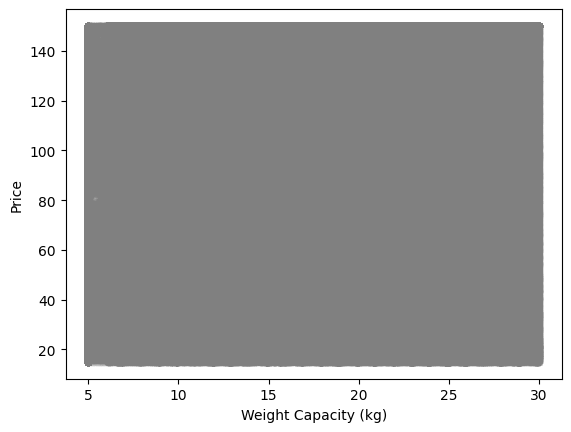

In [15]:
sns.scatterplot(data= training_data_combined,
                x = "Weight Capacity (kg)",
                y = "Price",
                color = "grey",
                alpha = 0.01
               )

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


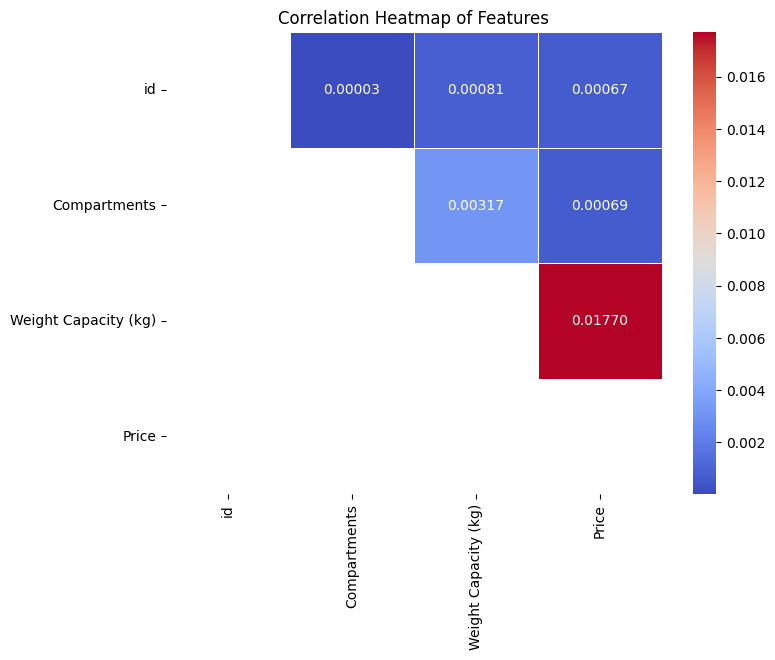

In [16]:
# let's use a correlation coefficient to determine which features to filter out
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

numeric_features = training_data_combined.select_dtypes(include=['int64','int32','float64']).columns.tolist()

# create correlation matrix
corr_matrix = training_data_combined[numeric_features].corr().abs()

# the upper triangle of correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# plot the heatmap of the upper triangle
plt.figure(figsize=(8, 6))
sns.heatmap(upper_triangle, annot=True, cmap='coolwarm', fmt=".5f", linewidths=.5)
plt.title('Correlation Heatmap of Features')
plt.show()

# Make a new feature using clustering

In [17]:
training_data_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 335.2+ MB


In [18]:
cluster_features = ["Brand", "Material", "Laptop Compartment", "Waterproof", "Style"]

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# one hot encoding
training_data_encoded = pd.get_dummies(training_data_combined[cluster_features], drop_first=True)

# standardize
scaler = StandardScaler()
training_data_encoded_scaled = scaler.fit_transform(training_data_encoded)

kmeans = KMeans(n_clusters=5, random_state=42)
training_data_combined["cluster"] = kmeans.fit_predict(training_data_encoded_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
training_data_combined.sample(2)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,cluster
2329385,2529385,Under Armour,Polyester,Small,7.0,No,No,Tote,Black,7.241812,95.70197,1
562455,762455,Under Armour,Canvas,Large,6.0,Yes,No,Tote,Blue,27.939838,21.13930,1


In [21]:
training_data_combined['cluster'].value_counts()

cluster
4    974128
1    801035
3    755778
2    749340
0    714037
Name: count, dtype: int64

In [22]:
# choose features to use in regression model
numeric_features = ['Compartments', 'Weight Capacity (kg)']
nominal_features = ['cluster']
ordinal_features = ['Size']

all_features = numeric_features + nominal_features + ordinal_features
all_features

from sklearn.model_selection import train_test_split

X = training_data_combined[all_features]

y = training_data_combined['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"""size of training set: {len(X_train)}
size of testing set: {len(X_test)}""")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define the transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('scaler', StandardScaler())
                               ])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Small','Medium', 'Large']]))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, numeric_features),
        ('nominal_transformer', nominal_transformer, nominal_features),
        ('ordinal_transformer', ordinal_transformer, ordinal_features)])

preprocessor

size of training set: 3195454
size of testing set: 798864


ColumnTransformer(transformers=[('numeric_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['Compartments', 'Weight Capacity (kg)']),
                                ('nominal_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['cluster']),
                                ('ordinal_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'Large']]))]),
                                 ['Size'])])

In [23]:
from sklearn.linear_model import LinearRegression

# define the pipeline with the preprocessor and the Linear Regression
LR_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LinearRegression())])

# train the model
LR_model.fit(X_train, y_train)

# print the model
LR_model

from sklearn.metrics import mean_squared_error
import numpy as np

# make prdictions on the training data
LR_predictions = LR_model.predict(X_test)
rmse = mean_squared_error(y_test, LR_predictions, squared=False)
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 38.9079021696933


In [24]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the pipeline with the preprocessor and the Gradient Boosting Regressor
GB_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))])

# Train the model
GB_model.fit(X_train, y_train)

# Print the model
GB_model


from sklearn.metrics import mean_squared_error
import numpy as np
# Make predictions on the test data
GB_predictions = GB_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, GB_predictions, squared=False)
print(f"Root Mean Square Error (RMSE): {rmse}")


Root Mean Square Error (RMSE): 38.88654330197


# Make predictions on the Testing Data, and submit to competiton.

In [25]:
# make clusters on testing data
testing_data_encoded = pd.get_dummies(testing_data[cluster_features], drop_first=True)
testing_data_encoded_scaled = scaler.fit_transform(testing_data_encoded)
testing_data["cluster"] = kmeans.fit_predict(testing_data_encoded_scaled)

# make predictions on the test set
final_predictions = LR_model.predict(testing_data)

# turn your predictions into a list
final_predictions = final_predictions.tolist()

# make your predictions into a dataframe
submission_df = pd.DataFrame({"id" : testing_data["id"],
                              "Price" : final_predictions})

# print a value count from the predictions
submission_df.sample(3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,id,Price
153996,453996,81.318726
4314,304314,81.426514
96915,396915,81.905396


In [26]:
# make clusters on testing data
testing_data_encoded = pd.get_dummies(testing_data[cluster_features], drop_first=True)
testing_data_encoded_scaled = scaler.fit_transform(testing_data_encoded)
testing_data["cluster"] = kmeans.fit_predict(testing_data_encoded_scaled)

# make predictions on the test set
final_predictions = GB_model.predict(testing_data)

# turn your predictions into a list
final_predictions = final_predictions.tolist()

# make your predictions into a dataframe
submission_df = pd.DataFrame({"id" : testing_data["id"],
                              "Price" : final_predictions})

# print a value count from the predictions
submission_df.sample(3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,id,Price
4070,304070,82.536597
34496,334496,81.361291
119768,419768,81.191237


In [27]:
submission_df.to_csv("submission.csv", index = False)